# Santander Customer Transaction Prediction - Decision Tree

In the Kaggle competition, the objective is to identify which customer will make a transaction in the future.

**Link to the competition**: https://www.kaggle.com/c/santander-customer-transaction-prediction/  
**Type of Problem**: Classification  
**Metric for evalution**: AOC (Area Under Curve)

This Python 3 environment comes with many helpful analytics libraries installed
It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn import metrics

import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

In [2]:
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/santander-customer-transaction-prediction/sample_submission.csv
/kaggle/input/santander-customer-transaction-prediction/train.csv
/kaggle/input/santander-customer-transaction-prediction/test.csv


## Step1: Read the datasets

In [3]:
input_dir = '/kaggle/input/santander-customer-transaction-prediction/'

df_train = pd.read_csv(input_dir + 'train.csv')
df_train

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,...,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,...,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,train_199995,0,11.4880,-0.4956,8.2622,3.5142,10.3404,11.6081,5.6709,15.1516,...,6.1415,13.2305,3.9901,0.9388,18.0249,-1.7939,2.1661,8.5326,16.6660,-17.8661
199996,train_199996,0,4.9149,-2.4484,16.7052,6.6345,8.3096,-10.5628,5.8802,21.5940,...,4.9611,4.6549,0.6998,1.8341,22.2717,1.7337,-2.1651,6.7419,15.9054,0.3388
199997,train_199997,0,11.2232,-5.0518,10.5127,5.6456,9.3410,-5.4086,4.5555,21.5571,...,4.0651,5.4414,3.1032,4.8793,23.5311,-1.5736,1.2832,8.7155,13.8329,4.1995
199998,train_199998,0,9.7148,-8.6098,13.6104,5.7930,12.5173,0.5339,6.0479,17.0152,...,2.6840,8.6587,2.7337,11.1178,20.4158,-0.0786,6.7980,10.0342,15.5289,-13.9001


We already know the profile of data based on the overview provide by Kaggle.  
Let us confirm the event rate for the training data. Event rate is approx 10%

In [4]:
df_train.groupby('target').size()

target
0    179902
1     20098
dtype: int64

## Step2: Split the data into training and validation data
20% of data would be kept for validation

In [5]:
var_columns = [c for c in df_train.columns if c not in ['ID_code','target']]
X = df_train.loc[:,var_columns]
y = df_train.loc[:,'target']

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((160000, 200), (40000, 200), (160000,), (40000,))

## Step3: Simple decision tree

Let us try to use a simple decision tree to predict the target variable.  
Also plot the tree to make sure it looks fine.

In [6]:
model_tree = DecisionTreeClassifier(max_leaf_nodes=8, class_weight='balanced')
model_tree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', max_leaf_nodes=8)

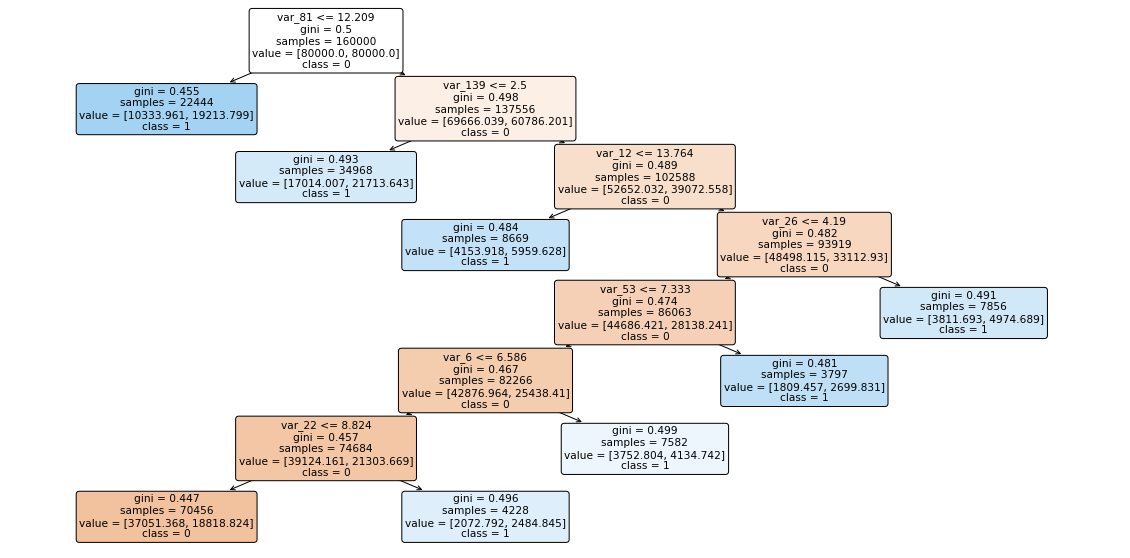

In [7]:
#Create the figure
plt.figure(figsize=(20,10))

#Create the tree plot
plot_tree(model_tree,
           feature_names = var_columns, #Feature names
           class_names = ["0","1"], #Class names
           rounded = True,
           filled = True)

plt.show()

Let us look at the training and validation performance

In [8]:
y_train_pred = model_tree.predict(X_train)
y_valid_pred = model_tree.predict(X_valid)

In [9]:
auc_train = metrics.roc_auc_score(y_train, y_train_pred)
auc_valid = metrics.roc_auc_score(y_valid, y_valid_pred)

print("AUC Train = {}\nAUC Valid = {}".format(round(auc_train,4), round(auc_valid,4)))

AUC Train = 0.614
AUC Valid = 0.6077


## Step4: Iterate over number of leaf nodes
Let us iterate through the steps to find the appropriate level of tree depth (max leaf nodes)  
For that, we will write all steps as a function and call that function in loop

In [10]:
def tree_training(max_leaf_nodes, X_train, y_train, X_valid, y_valid):
    model_tree = DecisionTreeClassifier(max_leaf_nodes=max_leaf_nodes, class_weight='balanced')
    model_tree.fit(X_train, y_train)
    
    y_train_pred = model_tree.predict(X_train)
    y_valid_pred = model_tree.predict(X_valid)
    
    auc_train = metrics.roc_auc_score(y_train, y_train_pred)
    auc_valid = metrics.roc_auc_score(y_valid, y_valid_pred)
    
    print("Nodes:{}, Train:{:.4f}, Valid:{:.4f}, Diff:{:.4f}".format(max_leaf_nodes,
                                                                     auc_train,
                                                                     auc_valid,
                                                                     auc_train-auc_valid))
          

# Run few iterations to find which max_tree_nodes works best
for i in range(2, 20):
    tree_training(i, X_train, y_train, X_valid, y_valid)

Nodes:2, Train:0.5555, Valid:0.5515, Diff:0.0040
Nodes:3, Train:0.5849, Valid:0.5874, Diff:-0.0026
Nodes:4, Train:0.5962, Valid:0.5987, Diff:-0.0025
Nodes:5, Train:0.6034, Valid:0.6046, Diff:-0.0012
Nodes:6, Train:0.6090, Valid:0.6090, Diff:-0.0000
Nodes:7, Train:0.6114, Valid:0.6060, Diff:0.0053
Nodes:8, Train:0.6140, Valid:0.6077, Diff:0.0062
Nodes:9, Train:0.6153, Valid:0.6088, Diff:0.0066
Nodes:10, Train:0.6153, Valid:0.6088, Diff:0.0066
Nodes:11, Train:0.6170, Valid:0.6084, Diff:0.0086
Nodes:12, Train:0.6170, Valid:0.6084, Diff:0.0086
Nodes:13, Train:0.6170, Valid:0.6084, Diff:0.0086
Nodes:14, Train:0.6170, Valid:0.6084, Diff:0.0086
Nodes:15, Train:0.6182, Valid:0.6026, Diff:0.0157
Nodes:16, Train:0.6182, Valid:0.6026, Diff:0.0157
Nodes:17, Train:0.6189, Valid:0.6025, Diff:0.0164
Nodes:18, Train:0.6189, Valid:0.6025, Diff:0.0164
Nodes:19, Train:0.6248, Valid:0.6096, Diff:0.0153


The performance on validation data peaks with less number of nodes. It appears that we don't need very high number of leaf nodes.  

At `6 leaf nodes`, we are getting the highest validation AUC. Performance of the model on train and validation is virtually the same.

## Step5: k-fold cross validation

Looking at the result, I felt the need to perform a k-fold cross validation. Let us try `5-fold cross validation`

In [11]:
kfold = KFold(5, shuffle=True, random_state=1)

for idx_train, idx_valid in kfold.split(df_train):
    X_train = df_train.loc[idx_train, var_columns]
    y_train = df_train.loc[idx_train, 'target']
    
    X_valid = df_train.loc[idx_valid, var_columns]
    y_valid = df_train.loc[idx_valid, 'target']
    
    # Try 10 leaf nodes, we saw lot of leaf nodes don't increase performance
    print("Iteration Starts")
    for i in range(2, 16):
        tree_training(i, X_train, y_train, X_valid, y_valid)
    
    print("Iteration Ends\n-----------------------")

Iteration Starts
Nodes:2, Train:0.5551, Valid:0.5548, Diff:0.0003
Nodes:3, Train:0.5856, Valid:0.5821, Diff:0.0035
Nodes:4, Train:0.5963, Valid:0.5896, Diff:0.0067
Nodes:5, Train:0.6031, Valid:0.5963, Diff:0.0068
Nodes:6, Train:0.6069, Valid:0.5989, Diff:0.0080
Nodes:7, Train:0.6069, Valid:0.5989, Diff:0.0080
Nodes:8, Train:0.6069, Valid:0.5989, Diff:0.0080
Nodes:9, Train:0.6096, Valid:0.6017, Diff:0.0079
Nodes:10, Train:0.6118, Valid:0.6014, Diff:0.0103
Nodes:11, Train:0.6118, Valid:0.6014, Diff:0.0103
Nodes:12, Train:0.6118, Valid:0.6014, Diff:0.0103
Nodes:13, Train:0.6118, Valid:0.6014, Diff:0.0103
Nodes:14, Train:0.6181, Valid:0.6076, Diff:0.0105
Nodes:15, Train:0.6181, Valid:0.6076, Diff:0.0105
Iteration Ends
-----------------------
Iteration Starts
Nodes:2, Train:0.5565, Valid:0.5489, Diff:0.0076
Nodes:3, Train:0.5862, Valid:0.5825, Diff:0.0037
Nodes:4, Train:0.5976, Valid:0.5892, Diff:0.0085
Nodes:5, Train:0.6053, Valid:0.5978, Diff:0.0075
Nodes:6, Train:0.6103, Valid:0.6016, Di

A better way to perform 5-fold cross validation is using the sklearn function `cross_val_score`  

I will iterate over the number of nodes and take average AUC for each iteration

In [12]:
# CV function requires a scorer of this form
def cv_roc_auc_scorer(model, X, y): return metrics.roc_auc_score(y, model.predict(X))

# Loop through multiple values of max_leaf_nodes to find best parameter
for num_leaf_node in range(2,16):
    model_tree = DecisionTreeClassifier(max_leaf_nodes=num_leaf_node, class_weight='balanced')
    kfold_scores = cross_validate(model_tree,
                                  X,
                                  y,
                                  cv=5,
                                  scoring=cv_roc_auc_scorer,
                                  return_train_score=True)

    # Find average train and test score
    train_auc_avg = np.mean(kfold_scores['train_score'])
    test_auc_avg = np.mean(kfold_scores['test_score'])

    print("Nodes:{}, Train:{:.4f}, Valid:{:.4f}, Diff:{:.4f}".format(num_leaf_node,
                                                                     train_auc_avg,
                                                                     test_auc_avg,
                                                                     train_auc_avg-test_auc_avg))

Nodes:2, Train:0.5548, Valid:0.5534, Diff:0.0014
Nodes:3, Train:0.5849, Valid:0.5805, Diff:0.0044
Nodes:4, Train:0.5963, Valid:0.5927, Diff:0.0036
Nodes:5, Train:0.6032, Valid:0.5992, Diff:0.0041
Nodes:6, Train:0.6065, Valid:0.6016, Diff:0.0049
Nodes:7, Train:0.6079, Valid:0.6026, Diff:0.0053
Nodes:8, Train:0.6084, Valid:0.6031, Diff:0.0052
Nodes:9, Train:0.6084, Valid:0.6031, Diff:0.0052
Nodes:10, Train:0.6093, Valid:0.6025, Diff:0.0068
Nodes:11, Train:0.6094, Valid:0.6024, Diff:0.0069
Nodes:12, Train:0.6123, Valid:0.6047, Diff:0.0076
Nodes:13, Train:0.6136, Valid:0.6062, Diff:0.0074
Nodes:14, Train:0.6144, Valid:0.6061, Diff:0.0083
Nodes:15, Train:0.6168, Valid:0.6083, Diff:0.0085


The best performance on validation set (with minimum number of trees) is for 8 nodes.  

## Step6: Final Model using Trees
The find model has `8 leaf nodes`. Let us create that model with entire training data and look at the output.

In [13]:
model_tree = DecisionTreeClassifier(max_leaf_nodes=8, class_weight='balanced')
model_tree.fit(X, y)

DecisionTreeClassifier(class_weight='balanced', max_leaf_nodes=8)

Print the final tree

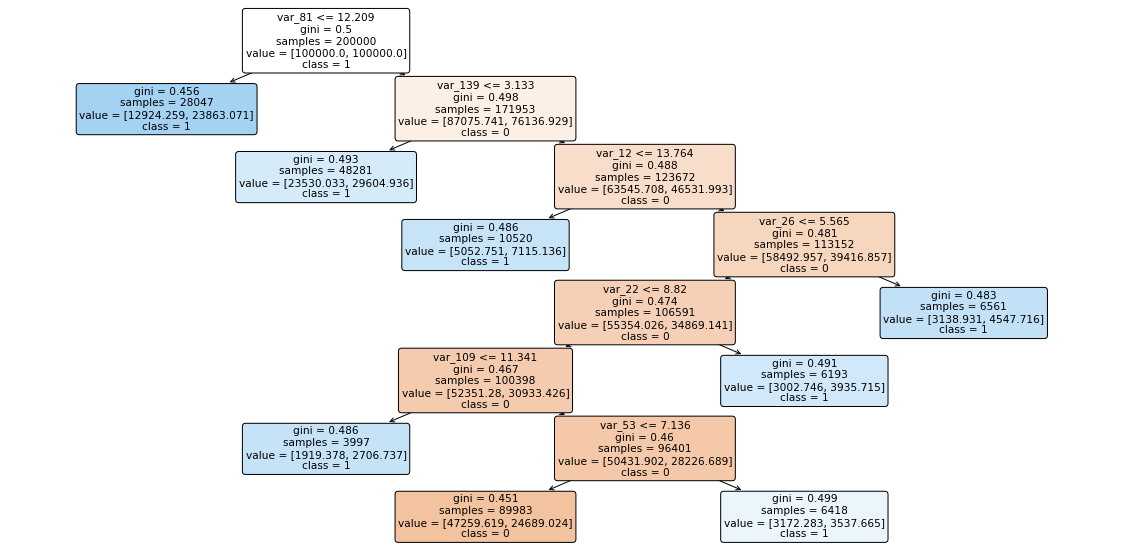

In [14]:
plt.figure(figsize=(20,10))

plot_tree(model_tree,
          feature_names=var_columns,
          class_names = ['0','1'],
          rounded=True,
          filled=True)

plt.show()

Let us find the final AUC value on training data  
And also plot the AUC curve

In [15]:
y_pred = model_tree.predict(X)

fpr, tpr, threshold = metrics.roc_curve(y, y_pred)
metrics.auc(fpr, tpr)

0.6128529767125377

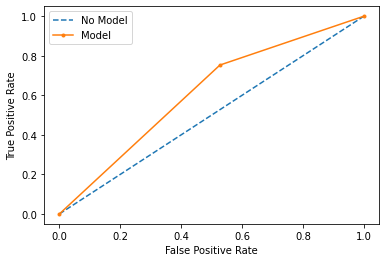

In [16]:
zeros_probs = [0 for _ in range(len(y))]
fpr_zeros, tpr_zeros, _ = metrics.roc_curve(y, zeros_probs)

# Plot the roc curve for the model
plt.plot(fpr_zeros, tpr_zeros, linestyle='--', label='No Model')
plt.plot(fpr, tpr, marker='.', label='Model')

# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# Add legend
plt.legend()

plt.show()

## Step7: Find Predictions for Test Data and store as final excel

In [17]:
df_test = pd.read_csv(input_dir + 'test.csv')
df_test

,ID_code,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,test_0,11.0656,7.7798,12.9536,9.4292,11.4327,-2.3805,5.8493,18.2675,2.1337,...,-2.1556,11.8495,-1.4300,2.4508,13.7112,2.4669,4.3654,10.7200,15.4722,-8.7197
1,test_1,8.5304,1.2543,11.3047,5.1858,9.1974,-4.0117,6.0196,18.6316,-4.4131,...,10.6165,8.8349,0.9403,10.1282,15.5765,0.4773,-1.4852,9.8714,19.1293,-20.9760
2,test_2,5.4827,-10.3581,10.1407,7.0479,10.2628,9.8052,4.8950,20.2537,1.5233,...,-0.7484,10.9935,1.9803,2.1800,12.9813,2.1281,-7.1086,7.0618,19.8956,-23.1794
3,test_3,8.5374,-1.3222,12.0220,6.5749,8.8458,3.1744,4.9397,20.5660,3.3755,...,9.5702,9.0766,1.6580,3.5813,15.1874,3.1656,3.9567,9.2295,13.0168,-4.2108
4,test_4,11.7058,-0.1327,14.1295,7.7506,9.1035,-8.5848,6.8595,10.6048,2.9890,...,4.2259,9.1723,1.2835,3.3778,19.5542,-0.2860,-5.1612,7.2882,13.9260,-9.1846
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,test_199995,13.1678,1.0136,10.4333,6.7997,8.5974,-4.1641,4.8579,14.7625,-2.7239,...,2.0544,9.6849,4.6734,-1.3660,12.8721,1.2013,-4.6195,9.1568,18.2102,4.8801
199996,test_199996,9.7171,-9.1462,7.3443,9.1421,12.8936,3.0191,5.6888,18.8862,5.0915,...,5.0071,6.6548,1.8197,2.4104,18.9037,-0.9337,2.9995,9.1112,18.1740,-20.7689
199997,test_199997,11.6360,2.2769,11.2074,7.7649,12.6796,11.3224,5.3883,18.3794,1.6603,...,5.1536,2.6498,2.4937,-0.0637,20.0609,-1.1742,-4.1524,9.1933,11.7905,-22.2762
199998,test_199998,13.5745,-0.5134,13.6584,7.4855,11.2241,-11.3037,4.1959,16.8280,5.3208,...,3.4259,8.5012,2.2713,5.7621,17.0056,1.1763,-2.3761,8.1079,8.7735,-0.2122


In [18]:
X_test = df_test.loc[:, var_columns]
y_test_pred  = model_tree.predict(X_test)

In [19]:
df_sample_subm = pd.read_csv(input_dir + 'sample_submission.csv')
df_sample_subm

,ID_code,target
0,test_0,0
1,test_1,0
2,test_2,0
3,test_3,0
4,test_4,0
...,...,...
199995,test_199995,0
199996,test_199996,0
199997,test_199997,0
199998,test_199998,0


In [20]:
df_sample_subm['target'] = y_test_pred
df_sample_subm

,ID_code,target
0,test_0,1
1,test_1,0
2,test_2,1
3,test_3,0
4,test_4,1
...,...,...
199995,test_199995,0
199996,test_199996,0
199997,test_199997,0
199998,test_199998,1


In [21]:
output_dir = '/kaggle/working/'
df_sample_subm.to_csv(output_dir + '/01_tree_scores.csv', index=False)